# UNet Fine Tuning

## Importing Modules

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import os
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"On Device: {device}")

On Device: cuda


### Drive Mount

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


## Defining Dataset and DataLoader

In [ ]:
train_path_list = []
test_path_list = []

In [ ]:
# train data path list
clean_train_paths = sorted(os.listdir('/content/drive/MyDrive/Restoring Brain CT and Brain MRI/data/Images/train'))
blurred_train_paths = sorted(os.listdir('/content/drive/MyDrive/Restoring Brain CT and Brain MRI/data/Images/blurred_train'))

for clean, blur in zip(clean_train_paths, blurred_train_paths):
    train_path_list.append([
        os.path.join('/content/drive/MyDrive/Restoring Brain CT and Brain MRI/data/Images/train', clean),
        os.path.join('/content/drive/MyDrive/Restoring Brain CT and Brain MRI/data/Images/blurred_train', blur)
    ])

# test data path list
clean_test_paths = sorted(os.listdir('/content/drive/MyDrive/Restoring Brain CT and Brain MRI/data/Images/test'))
blurred_test_paths = sorted(os.listdir('/content/drive/MyDrive/Restoring Brain CT and Brain MRI/data/Images/blurred_test'))

for clean, blur in zip(clean_test_paths, blurred_test_paths):
    test_path_list.append([
        os.path.join('/content/drive/MyDrive/Restoring Brain CT and Brain MRI/data/Images/test', clean),
        os.path.join('/content/drive/MyDrive/Restoring Brain CT and Brain MRI/data/Images/blurred_test', blur)
    ])

In [ ]:
# defining dataset
class dataset(Dataset):

  def __init__(self, img_list, data_transform):
    super().__init__()
    self.input = img_list
    self.transforms = data_transform

  def __len__(self):
    return len(self.input)

  def __getitem__(self, idx):
    target_img = Image.open(self.input[idx][0]).convert("RGB")
    train_img = Image.open(self.input[idx][1]).convert("RGB")

    target_img = self.transforms(target_img)
    train_img = self.transforms(train_img)

    return train_img, target_img

In [ ]:
img_transforms = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(torch.tensor([0.1317, 0.1317, 0.1318]), torch.tensor([0.2261, 0.2261, 0.2261]))
])

In [ ]:
train_data = dataset(train_path_list, img_transforms)
test_data = dataset(test_path_list, img_transforms)

In [ ]:
len(train_data), len(test_data)

(5235, 36)

In [ ]:
BATCH_SIZE = 32
RANDOM_SEED = 42

torch.cuda.manual_seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
# defining dataloader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=os.cpu_count())

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=os.cpu_count())

In [ ]:
len(train_dataloader), len(test_dataloader)

(164, 2)

## Training

In [ ]:
%cd /content/drive/MyDrive/Restoring\ Brain\ CT\ and\ Brain\ MRI/
from model_trainer import train

/content/drive/MyDrive/Restoring Brain CT and Brain MRI


In [ ]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True).to(device)

Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/releases/download/v1.0/unet-e012d006.pt" to /root/.cache/torch/hub/checkpoints/unet-e012d006.pt


In [ ]:
model.conv = nn.Conv2d(32, 3, kernel_size=(1, 1), stride = (1, 1)).to(device)

In [ ]:
model

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [ ]:
# loading model trained for 40 epochs
model.load_state_dict(torch.load("/content/drive/MyDrive/Restoring Brain CT and Brain MRI/models/unet_epoch60.pth"))

model.to(device)

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [ ]:
loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(params=model.parameters(),
                             lr = 0.00005)

scheduler = torch.optim.lr_scheduler.LinearLR(optimizer,
                                              start_factor = 1.0,
                                              end_factor = 1.0,
                                              total_iters = 20)

In [ ]:
folder_path = "/content/drive/MyDrive/Restoring Brain CT and Brain MRI/epochs_output/unet4/" # saving first test image's output after every epoch
EPOCHS1 = 20

train_loss1, test_loss1, test_ssim1, test_psnr1 = train(model,
                                                        optimizer,
                                                        loss_fn,
                                                        scheduler,
                                                        train_dataloader,
                                                        test_dataloader,
                                                        EPOCHS1,
                                                        test_path_list,
                                                        img_transforms,
                                                        device,
                                                        save_output_path = folder_path
                                                        )

  0%|          | 0/20 [00:00<?, ?it/s]

===EPOCH: 1===

Training...



  0%|          | 0/164 [00:00<?, ?it/s]

Testing...



  0%|          | 0/2 [00:00<?, ?it/s]

Training Loss: 0.78835 | Test Loss: 0.68643 | Test SSIM: 14.97647 | Test PSNR: 0.01616

===EPOCH: 2===

Training...



  0%|          | 0/164 [00:00<?, ?it/s]

Testing...



  0%|          | 0/2 [00:00<?, ?it/s]

Training Loss: 0.78716 | Test Loss: 0.68149 | Test SSIM: 15.01953 | Test PSNR: 0.01917

===EPOCH: 3===

Training...



  0%|          | 0/164 [00:00<?, ?it/s]

Testing...



  0%|          | 0/2 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fdbcdaaa020>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fdbcdaaa020>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Training Loss: 0.78645 | Test Loss: 0.68468 | Test SSIM: 14.98943 | Test PSNR: 0.01793

===EPOCH: 4===

Training...



  0%|          | 0/164 [00:00<?, ?it/s]

Testing...



  0%|          | 0/2 [00:00<?, ?it/s]

Training Loss: 0.78487 | Test Loss: 0.68777 | Test SSIM: 14.97006 | Test PSNR: 0.01790

===EPOCH: 5===

Training...



  0%|          | 0/164 [00:00<?, ?it/s]

Testing...



  0%|          | 0/2 [00:00<?, ?it/s]

Training Loss: 0.78443 | Test Loss: 0.69099 | Test SSIM: 14.94450 | Test PSNR: 0.01618

===EPOCH: 6===

Training...



  0%|          | 0/164 [00:00<?, ?it/s]

Testing...



  0%|          | 0/2 [00:00<?, ?it/s]

Training Loss: 0.78405 | Test Loss: 0.69280 | Test SSIM: 14.93025 | Test PSNR: 0.01492

===EPOCH: 7===

Training...



  0%|          | 0/164 [00:00<?, ?it/s]

Testing...



  0%|          | 0/2 [00:00<?, ?it/s]

Training Loss: 0.78264 | Test Loss: 0.69986 | Test SSIM: 14.87772 | Test PSNR: 0.01286

===EPOCH: 8===

Training...



  0%|          | 0/164 [00:00<?, ?it/s]

Testing...



  0%|          | 0/2 [00:00<?, ?it/s]

Training Loss: 0.78146 | Test Loss: 0.69085 | Test SSIM: 14.94942 | Test PSNR: 0.01808

===EPOCH: 9===

Training...



  0%|          | 0/164 [00:00<?, ?it/s]

Testing...



  0%|          | 0/2 [00:00<?, ?it/s]

Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fdbcdaaa020>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fdbcdaaa020>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1

Training Loss: 0.78074 | Test Loss: 0.69627 | Test SSIM: 14.89929 | Test PSNR: 0.01433

===EPOCH: 10===

Training...



  0%|          | 0/164 [00:00<?, ?it/s]

Testing...



  0%|          | 0/2 [00:00<?, ?it/s]

Training Loss: 0.77987 | Test Loss: 0.68978 | Test SSIM: 14.96209 | Test PSNR: 0.01704

===EPOCH: 11===

Training...



  0%|          | 0/164 [00:00<?, ?it/s]

Testing...



  0%|          | 0/2 [00:00<?, ?it/s]

Training Loss: 0.77822 | Test Loss: 0.69630 | Test SSIM: 14.89889 | Test PSNR: 0.01412

===EPOCH: 12===

Training...



  0%|          | 0/164 [00:00<?, ?it/s]

Testing...



  0%|          | 0/2 [00:00<?, ?it/s]

Training Loss: 0.77852 | Test Loss: 0.69385 | Test SSIM: 14.92876 | Test PSNR: 0.01662

===EPOCH: 13===

Training...



  0%|          | 0/164 [00:00<?, ?it/s]

Testing...



  0%|          | 0/2 [00:00<?, ?it/s]

Training Loss: 0.77739 | Test Loss: 0.69655 | Test SSIM: 14.90493 | Test PSNR: 0.01576

===EPOCH: 14===

Training...



  0%|          | 0/164 [00:00<?, ?it/s]

Testing...



  0%|          | 0/2 [00:00<?, ?it/s]

Training Loss: 0.77626 | Test Loss: 0.69016 | Test SSIM: 14.95957 | Test PSNR: 0.01873

===EPOCH: 15===

Training...



  0%|          | 0/164 [00:00<?, ?it/s]

Testing...



  0%|          | 0/2 [00:00<?, ?it/s]

Training Loss: 0.77501 | Test Loss: 0.69550 | Test SSIM: 14.92591 | Test PSNR: 0.01780

===EPOCH: 16===

Training...



  0%|          | 0/164 [00:00<?, ?it/s]

Testing...



  0%|          | 0/2 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fdbcdaaa020>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Training Loss: 0.77418 | Test Loss: 0.69913 | Test SSIM: 14.89676 | Test PSNR: 0.01678

===EPOCH: 17===

Training...



  0%|          | 0/164 [00:00<?, ?it/s]

Testing...



  0%|          | 0/2 [00:00<?, ?it/s]

Training Loss: 0.77372 | Test Loss: 0.69986 | Test SSIM: 14.88798 | Test PSNR: 0.01695

===EPOCH: 18===

Training...



  0%|          | 0/164 [00:00<?, ?it/s]

Testing...



  0%|          | 0/2 [00:00<?, ?it/s]

Training Loss: 0.77293 | Test Loss: 0.69412 | Test SSIM: 14.92416 | Test PSNR: 0.01771

===EPOCH: 19===

Training...



  0%|          | 0/164 [00:00<?, ?it/s]

Testing...



  0%|          | 0/2 [00:00<?, ?it/s]

Training Loss: 0.77158 | Test Loss: 0.69928 | Test SSIM: 14.88335 | Test PSNR: 0.01592

===EPOCH: 20===

Training...



  0%|          | 0/164 [00:00<?, ?it/s]

Testing...



  0%|          | 0/2 [00:00<?, ?it/s]

Training Loss: 0.77265 | Test Loss: 0.70142 | Test SSIM: 14.86465 | Test PSNR: 0.01673


Train time on cuda: 3757.648 seconds


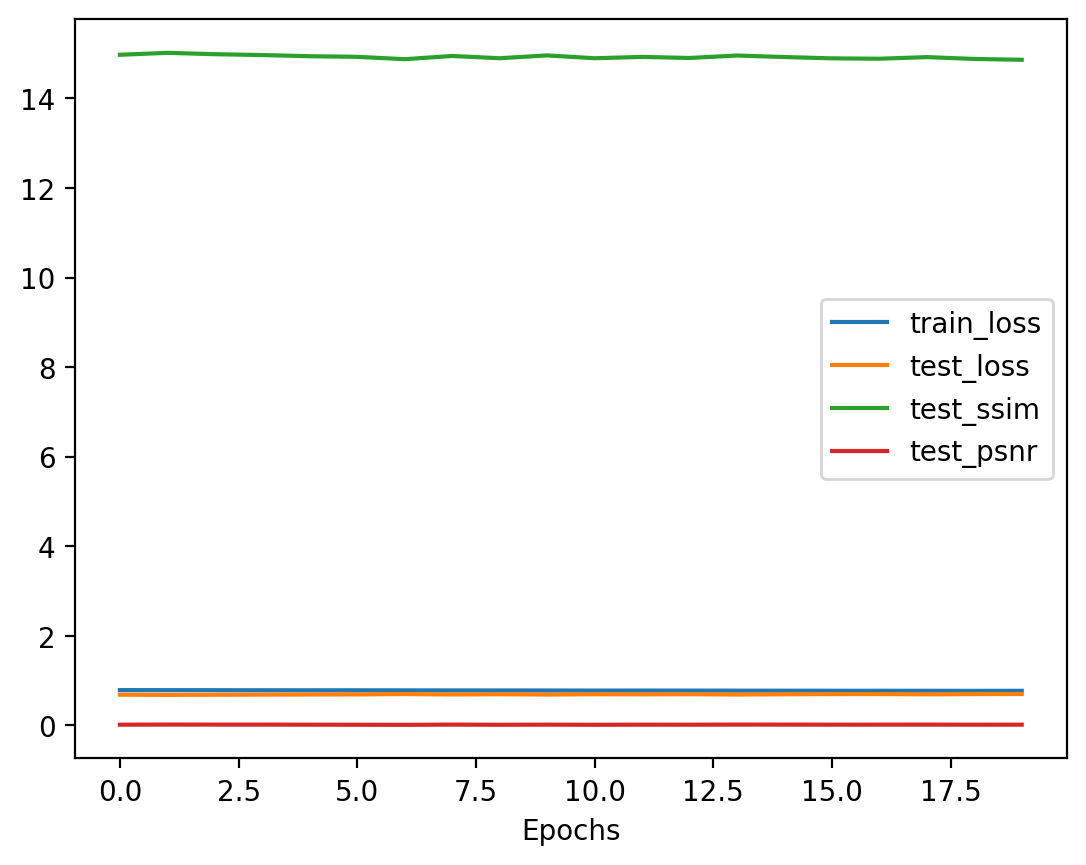

In [ ]:
plt.plot(train_loss1, label='train_loss')
plt.plot(test_loss1, label='test_loss')
plt.plot(test_ssim1, label='test_ssim')
plt.plot(test_psnr1, label='test_psnr')

plt.xlabel("Epochs")
plt.legend()
plt.show()

In [ ]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("/content/drive/MyDrive/Restoring Brain CT and Brain MRI/models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "unet_epoch60.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)
print("Done!")

Saving model to: /content/drive/MyDrive/Restoring Brain CT and Brain MRI/models/unet_epoch60.pth
Done!


continued...

In [ ]:
loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(params=model.parameters(),
                             lr = 0.0001)

scheduler = torch.optim.lr_scheduler.LinearLR(optimizer,
                                              start_factor = 1.0,
                                              end_factor = 1.0,
                                              total_iters = 10)

In [23]:
folder_path = "/content/drive/MyDrive/Restoring Brain CT and Brain MRI/epochs_output/unet5/" # saving first test image's output after every epoch
EPOCHS2 = 10

train_loss2, test_loss2, test_ssim2, test_psnr2 = train(model,
                                                        optimizer,
                                                        loss_fn,
                                                        scheduler,
                                                        train_dataloader,
                                                        test_dataloader,
                                                        EPOCHS2,
                                                        test_path_list,
                                                        img_transforms,
                                                        device,
                                                        save_output_path = folder_path
                                                        )

  0%|          | 0/10 [00:00<?, ?it/s]

===EPOCH: 1===

Training...



  0%|          | 0/164 [00:00<?, ?it/s]

Testing...



  0%|          | 0/2 [00:00<?, ?it/s]

Training Loss: 0.77238 | Test Loss: 0.70515 | Test SSIM: 14.84382 | Test PSNR: 0.01270

===EPOCH: 2===

Training...



  0%|          | 0/164 [00:00<?, ?it/s]

Testing...



  0%|          | 0/2 [00:00<?, ?it/s]

Training Loss: 0.77230 | Test Loss: 0.70553 | Test SSIM: 14.83554 | Test PSNR: 0.01423

===EPOCH: 3===

Training...



  0%|          | 0/164 [00:00<?, ?it/s]

Testing...



  0%|          | 0/2 [00:00<?, ?it/s]

Training Loss: 0.77204 | Test Loss: 0.69834 | Test SSIM: 14.89959 | Test PSNR: 0.01684

===EPOCH: 4===

Training...



  0%|          | 0/164 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fdbcdaaa020>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fdbcdaaa020>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Testing...



  0%|          | 0/2 [00:00<?, ?it/s]

Training Loss: 0.76963 | Test Loss: 0.70116 | Test SSIM: 14.87780 | Test PSNR: 0.01691

===EPOCH: 5===

Training...



  0%|          | 0/164 [00:00<?, ?it/s]

Testing...



  0%|          | 0/2 [00:00<?, ?it/s]

Training Loss: 0.76850 | Test Loss: 0.69822 | Test SSIM: 14.89370 | Test PSNR: 0.01692

===EPOCH: 6===

Training...



  0%|          | 0/164 [00:00<?, ?it/s]

Testing...



  0%|          | 0/2 [00:00<?, ?it/s]

Training Loss: 0.76700 | Test Loss: 0.71045 | Test SSIM: 14.80449 | Test PSNR: 0.01329

===EPOCH: 7===

Training...



  0%|          | 0/164 [00:00<?, ?it/s]

Testing...



  0%|          | 0/2 [00:00<?, ?it/s]

Training Loss: 0.76590 | Test Loss: 0.70185 | Test SSIM: 14.85748 | Test PSNR: 0.01394

===EPOCH: 8===

Training...



  0%|          | 0/164 [00:00<?, ?it/s]

Testing...



  0%|          | 0/2 [00:00<?, ?it/s]

Training Loss: 0.76485 | Test Loss: 0.68728 | Test SSIM: 14.99029 | Test PSNR: 0.02306

===EPOCH: 9===

Training...



  0%|          | 0/164 [00:00<?, ?it/s]

Testing...



  0%|          | 0/2 [00:00<?, ?it/s]

Training Loss: 0.76479 | Test Loss: 0.70389 | Test SSIM: 14.85196 | Test PSNR: 0.01560

===EPOCH: 10===

Training...



  0%|          | 0/164 [00:00<?, ?it/s]

Testing...



  0%|          | 0/2 [00:00<?, ?it/s]

Training Loss: 0.76205 | Test Loss: 0.70596 | Test SSIM: 14.83719 | Test PSNR: 0.01514


Train time on cuda: 1457.372 seconds


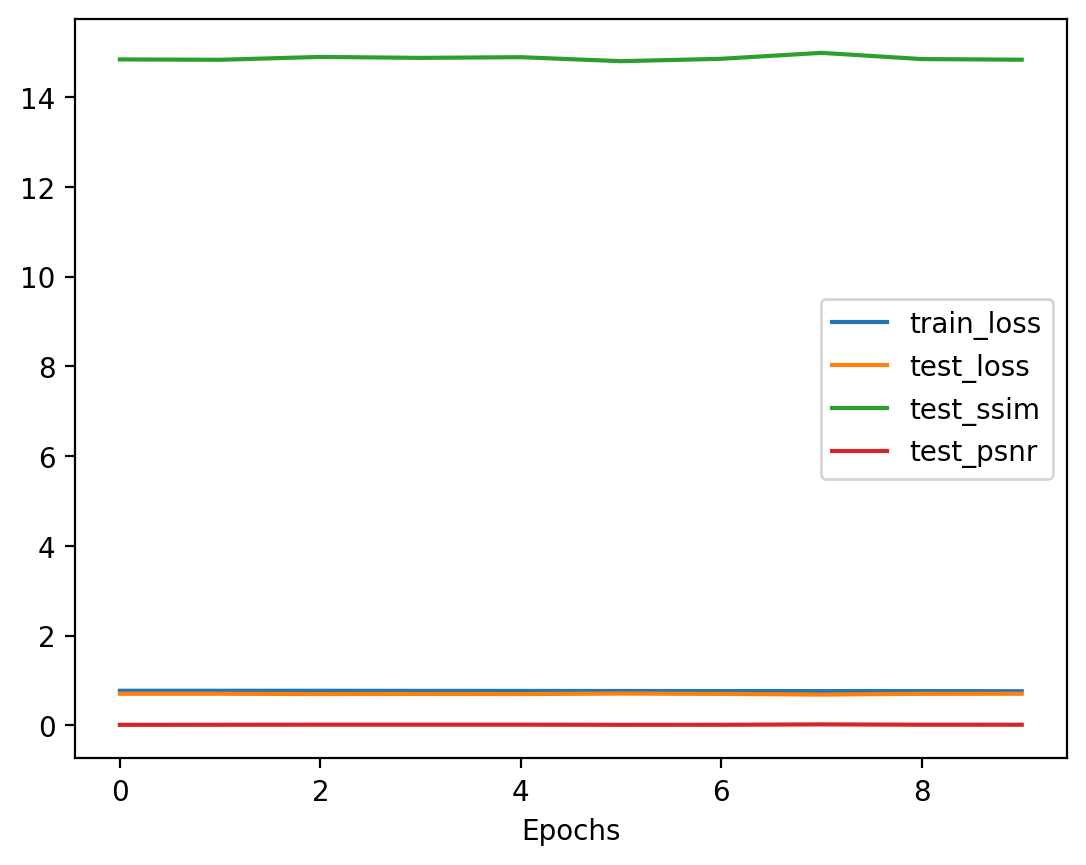

In [24]:
plt.plot(train_loss2, label='train_loss')
plt.plot(test_loss2, label='test_loss')
plt.plot(test_ssim2, label='test_ssim')
plt.plot(test_psnr2, label='test_psnr')

plt.xlabel("Epochs")
plt.legend()
plt.show()

In [25]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("/content/drive/MyDrive/Restoring Brain CT and Brain MRI/models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "unet_epoch70.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)
print("Done!")

Saving model to: /content/drive/MyDrive/Restoring Brain CT and Brain MRI/models/unet_epoch70.pth
Done!
